In [11]:
import pandas as pd
train_path = r'/Users/brianwang/Desktop/2025 National Inter-University Research Project/Constraint_Train.csv'
df_train = pd.read_csv(train_path)

# display roles
df_train.shape
df_train.head()

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,real
1,2,States reported 1121 deaths a small rise from ...,real
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,5,Populous states can generate large case counts...,real


In [13]:
print(df_train['label'].value_counts()) # fake vs. real counts

label
real    3360
fake    3060
Name: count, dtype: int64


In [17]:
import pandas as pd, re, string
from sklearn.model_selection import train_test_split

# Normalizes raw tweets by stripping out noise (links, handles, punctuation) so models focus on real words
def clean(text: str) -> str:
    text = re.sub(r"http\S+|www\S+", "", text)        # strip URLs
    text = re.sub(r"@\w+", "", text)                  # strip @handles
    text = re.sub(r"#", "", text)                     # drop '#' but keep tag word
    text = text.translate(str.maketrans("", "", string.punctuation))
    return text.lower().strip()

df_train["tweet_clean"] = df_train["tweet"].astype(str).apply(clean)

# Encode labels
label_map = {"fake": 0, "real": 1}
df_train["label_int"] = df_train["label"].map(label_map)

# Train-dev split (90 / 10, stratified)
# Keeps 90% of examples for fitting the model and 10% aside to check performance, 
# while maintaining the same balance of fake vs. real in each.

X_train, X_dev, y_train, y_dev = train_test_split(
        df_train["tweet_clean"],
        df_train["label_int"],
        test_size=0.10,
        stratify=df_train["label_int"],
        random_state=42)

# For convenience: create DataFrames
train_split = pd.DataFrame({"text": X_train, "label": y_train})
dev_split   = pd.DataFrame({"text": X_dev,   "label": y_dev})

# Save the cleaned splits
train_split.to_csv("constraint_train_clean.csv", index=False)
dev_split.to_csv("constraint_dev_clean.csv", index=False)

print("Done.  Training rows:", len(train_split), "  Dev rows:", len(dev_split))


✅ Done.  Training rows: 5778   Dev rows: 642


In [19]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# Load the cleaned splits
train = r'/Users/brianwang/Desktop/2025 National Inter-University Research Project/constraint_train_clean.csv'
df_train2 = pd.read_csv(train)

dev = r'/Users/brianwang/Desktop/2025 National Inter-University Research Project/constraint_dev_clean.csv'
df_dev = pd.read_csv(dev)

X_train, y_train = df_train2["text"], df_train2["label"]
X_dev, y_dev = df_dev["text"], df_dev["label"]

# 2. TF-IDF vectorization
# Learns a vocabulary of unigrams & bigrams from the training text 
# and transforms both train/dev into numeric feature matrices.
tfidf = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=2,
    stop_words="english")
Xtr = tfidf.fit_transform(X_train)
Xdv = tfidf.transform(X_dev)

# 3. Train Logistic Regression
clf = LogisticRegression(max_iter=200, random_state=42)
clf.fit(Xtr, y_train)

# 4. Predict & evaluate
preds = clf.predict(Xdv)
probs = clf.predict_proba(Xdv)[:,1]

print(classification_report(y_dev, preds, target_names=["fake","real"]))
print("ROC-AUC:", roc_auc_score(y_dev, probs))

# turning each tweet into a bag of word/phrase frequencies (TF-IDF), 
# training a simple and strong Logistic Regression to separate “fake” vs “real,” 
# and then measuring how well it performs on the development data. 
# This gives a baseline score F1 = 0.91, AUC = 0.97

              precision    recall  f1-score   support

        fake       0.90      0.92      0.91       306
        real       0.92      0.90      0.91       336

    accuracy                           0.91       642
   macro avg       0.91      0.91      0.91       642
weighted avg       0.91      0.91      0.91       642

ROC-AUC: 0.9718915343915344


In [21]:
import pandas as pd

# Predictions
Xdv = tfidf.transform(X_dev)               # reuse the TF-IDF object
preds = clf.predict(Xdv)                   # reuse the LogisticRegression

# Build errors DataFrame
errors = pd.DataFrame({
    "text":    X_dev,
    "true":    y_dev,
    "pred":    preds,
    "correct": (y_dev == preds)
})
errors = errors[~errors["correct"]]        # only the misclassified rows

# Inspect a random sample of 10
sample = errors.sample(10, random_state=42)
print(sample[["text","true","pred"]].to_string(index=False))

                                                                                                                                                                                                                                                                  text  true  pred
                              india beats russia 13m indians dont hv right 4 covid 19 tests free  wo efficient health infra v cant control community spreaderlow income poorselders more vulnerablefacing stigmas amp living in frustration  hang their heads in shame     0     1
                                                                                                                                         testing doesn’t create the virus even without diagnostics covid19 would still pose a problem we just would know less about it     0     1
                                                                                                                                                        a woman has fallen out 

In [31]:
import shap
from shap.maskers import Text
from sklearn.pipeline import make_pipeline

# Re-build pipeline
pipeline = make_pipeline(tfidf, clf)

# Sample 100 raw tweets from the TRAIN split as background
background = X_train.sample(100, random_state=42).tolist()

# Create a Text masker
masker = Text()

# Correct explainer call
explainer = shap.Explainer(
    pipeline.predict_proba,   # raw text to [P(fake), P(real)]
    masker=masker,            # tell SHAP this is text data
    data=background,          # background samples for masking
    output_names=["fake","real"]
)

# Now explain two error cases
for _, row in errors.sample(2, random_state=1).iterrows():
    sv = explainer([row["text"]])   # pass a list of raw tweets
    print(f"\n--- true={row['true']}  pred={row['pred']}  text snippet:")
    print(row["text"][:100], "…\n")
    shap.plots.text(sv[0])




--- true=1  pred=0  text snippet:
coronavirus christmas is the best time for new lockdown measures says oxford expert …




--- true=0  pred=1  text snippet:
who claimed that asymptomatic patients do not spread covid19 …



In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    token_pattern=r"\b[^\d\W]+\b",   # grab only alphabetic tokens
    ngram_range=(1,2),
    min_df=5,                        # token must appear in ≥5 docs
    max_df=0.8,                      # drop tokens in >80% of docs
    stop_words="english",
    sublinear_tf=True,               # replace tf with 1 + log(tf)
)

# Re-fit & re-evaluate
Xtr = tfidf.fit_transform(X_train)
Xdv = tfidf.transform(X_dev)

clf = LogisticRegression(max_iter=200, random_state=42, class_weight="balanced")
clf.fit(Xtr, y_train)

preds = clf.predict(Xdv)
probs = clf.predict_proba(Xdv)[:,1]

print(classification_report(y_dev, preds, target_names=["fake","real"]))
print("ROC-AUC:", roc_auc_score(y_dev, probs))


              precision    recall  f1-score   support

        fake       0.89      0.92      0.90       306
        real       0.92      0.90      0.91       336

    accuracy                           0.91       642
   macro avg       0.91      0.91      0.91       642
weighted avg       0.91      0.91      0.91       642

ROC-AUC: 0.9645337301587302


In [47]:
!pip install --upgrade datasets evaluate transformers pyarrow
# CPU-only build
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!pip install transformers


Looking in indexes: https://download.pytorch.org/whl/cpu
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 MB 22.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 25.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 29.1 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: sympy
    Found existing installation: sympy 1.12
    Uninstalling sympy-1.12:
      Successfully uninstalled sympy-1.12


In [53]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import pandas as pd
from tqdm.auto import tqdm

# 1) Prepare a simple PyTorch Dataset
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.enc = tokenizer(texts, truncation=True, padding=True, max_length=max_length)
        self.labels = labels
    def __len__(self): return len(self.labels)
    def __getitem__(self, i):
        item = {k: torch.tensor(v[i]) for k,v in self.enc.items()}
        item["labels"] = torch.tensor(self.labels[i])
        return item

# 2) Load data & tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

train = r'/Users/brianwang/Desktop/2025 National Inter-University Research Project/constraint_train_clean.csv'
df_train2 = pd.read_csv(train)
dev = r'/Users/brianwang/Desktop/2025 National Inter-University Research Project/constraint_dev_clean.csv'
df_dev = pd.read_csv(dev)

train_ds = TextDataset(df_train2.text.tolist(), df_train2.label.tolist(), tokenizer)
dev_ds   = TextDataset(df_dev.text.tolist(), df_dev.label.tolist(), tokenizer)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
dev_loader   = DataLoader(dev_ds,   batch_size=32)

# 3) Model & optimizer
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
optimizer = AdamW(model.parameters(), lr=2e-5)

# 4) Train for 1 epoch (expand to 3 with early-stop yourself)
model.train()
for batch in train_loader:
    optimizer.zero_grad()
    loss = model(**batch).loss
    loss.backward()
    optimizer.step()

# 5) Eval on dev
model.eval()
all_preds, all_probs, all_labels = [], [], []
with torch.no_grad():
    for batch in dev_loader:
        labels = batch["labels"].numpy()
        logits = model(**{k:v for k,v in batch.items() if k!="labels"})[0].numpy()
        probs  = torch.softmax(torch.tensor(logits), dim=-1)[:,1].numpy()
        preds  = logits.argmax(axis=-1)
        all_labels.extend(labels)
        all_preds.extend(preds)
        all_probs.extend(probs)

print("Acc:", accuracy_score(all_labels, all_preds))
print("F1:",  f1_score(all_labels, all_preds, average="weighted"))
print("AUC:", roc_auc_score(all_labels, all_probs))


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Acc: 0.9439252336448598
F1: 0.9439546434873538
AUC: 0.985167678182384


Using device: cpu


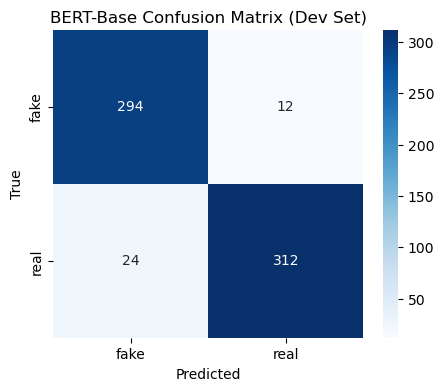

In [57]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"   # optional: suppress the warning

import torch
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Re-define your device (MPS if available, else CPU)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

# 2) Make sure your model is on that device
model.to(device)
model.eval()

# 3) Gather predictions & labels
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in dev_loader:
        # move inputs to device
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].numpy()
        
        # forward pass
        logits = model(input_ids=input_ids, attention_mask=attention_mask).logits
        probs = torch.softmax(logits, dim=-1)[:,1].cpu().numpy()
        preds = logits.argmax(dim=-1).cpu().numpy()
        
        all_labels.extend(labels)
        all_preds.extend(preds)

# 4) Compute & plot the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["fake","real"],
            yticklabels=["fake","real"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("BERT-Base Confusion Matrix (Dev Set)")
plt.show()


In [65]:
import pandas as pd

# Load
val = pd.read_csv(r'/Users/brianwang/Desktop/2025 National Inter-University Research Project/Constraint_Val.csv')

# Clean
val["tweet_clean"] = val["tweet"].apply(clean)            # your clean() function
val["label_int"]   = val["label"].map({"fake":0,"real":1})

# Evaluate TF-IDF baseline
X_val_tfidf = tfidf.transform(val["tweet_clean"])
val_preds   = clf.predict(X_val_tfidf)
print("Baseline on Val Split:\n", classification_report(val["label_int"], val_preds))


Baseline on Val Split:
               precision    recall  f1-score   support

           0       0.89      0.90      0.90      1020
           1       0.91      0.90      0.91      1120

    accuracy                           0.90      2140
   macro avg       0.90      0.90      0.90      2140
weighted avg       0.90      0.90      0.90      2140



In [69]:
# Evaluate on final test split
# a) Load & clean the test set
test_csv = r'/Users/brianwang/Desktop/2025 National Inter-University Research Project/english_test_with_labels.csv'
df_test  = pd.read_csv(test_csv)
df_test['text']     = df_test['tweet'].apply(clean)
df_test['label']    = df_test['label'].map({'fake':0,'real':1})

# b) Wrap in the same Dataset/DataLoader
test_ds     = TextDataset(df_test.text.tolist(), df_test.label.tolist(), tokenizer)
test_loader = DataLoader(test_ds, batch_size=32)

# c) Run evaluation
model.eval()
all_preds, all_probs, all_labels = [], [], []
with torch.no_grad():
    for batch in test_loader:
        labels = batch['labels'].numpy()
        logits = model(**{k:v for k,v in batch.items() if k!='labels'}).logits.cpu().numpy()
        probs  = torch.softmax(torch.tensor(logits), dim=-1)[:,1].numpy()
        preds  = logits.argmax(axis=-1)
        all_labels.extend(labels)
        all_preds.extend(preds)
        all_probs.extend(probs)

# d) Print metrics
from sklearn.metrics import classification_report, roc_auc_score
print("BERT on Final Test:")
print(classification_report(all_labels, all_preds, target_names=['fake','real']))
print("Test ROC-AUC:", roc_auc_score(all_labels, all_probs))


BERT on Final Test:
              precision    recall  f1-score   support

        fake       0.56      0.19      0.29      1020
        real       0.54      0.86      0.66      1120

    accuracy                           0.54      2140
   macro avg       0.55      0.53      0.47      2140
weighted avg       0.55      0.54      0.48      2140

Test ROC-AUC: 0.5392082457983194


In [81]:
from transformers import AutoModelForSequenceClassification
import torch

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# 2) Instantiate the same model architecture
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=2
)

# 3) Load the fine-tuned weights
state = torch.load("best_bert_constraint.pt", map_location=device)
model.load_state_dict(state)

# 4) Move to the right device and switch to eval
model.to(device)
model.eval()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [85]:
# 1. Instantiate architecture
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=2
)

# 2. Overwrite with fine-tuned weights
state = torch.load("best_bert_constraint.pt", map_location=device)
model.load_state_dict(state)

# 3. Move to device and eval
model.to(device)
model.eval()

# 4. Re-run your final-test evaluation cell

import pandas as pd
from torch.utils.data import DataLoader

# a) Load & clean the final test split
test_path = r'/Users/brianwang/Desktop/2025 National Inter-University Research Project/english_test_with_labels.csv'
df_test = pd.read_csv(test_path)
df_test["text"]  = df_test["tweet"].apply(clean)            # your clean() fn
df_test["label"] = df_test["label"].map({"fake":0,"real":1})

# b) Wrap it in your TextDataset & DataLoader
test_ds     = TextDataset(df_test["text"].tolist(), df_test["label"].tolist(), tokenizer)
test_loader = DataLoader(test_ds, batch_size=32)

# c) Run the evaluation
all_preds, all_probs, all_labels = [], [], []
with torch.no_grad():
    for batch in test_loader:
        # move inputs to same device as model
        inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
        labels = batch["labels"].numpy()
        
        logits = model(**inputs).logits.cpu().numpy()
        probs  = torch.softmax(torch.tensor(logits), dim=-1)[:,1].numpy()
        preds  = logits.argmax(axis=-1)
        
        all_labels.extend(labels)
        all_preds.extend(preds)
        all_probs.extend(probs)

# d) Print your true final metrics
from sklearn.metrics import classification_report, roc_auc_score
print("BERT on Final Test:")
print(classification_report(all_labels, all_preds, target_names=["fake","real"]))
print("Test ROC-AUC:", roc_auc_score(all_labels, all_probs))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERT on Final Test:
              precision    recall  f1-score   support

        fake       0.56      0.19      0.29      1020
        real       0.54      0.86      0.66      1120

    accuracy                           0.54      2140
   macro avg       0.55      0.53      0.47      2140
weighted avg       0.55      0.54      0.48      2140

Test ROC-AUC: 0.5392082457983194


In [87]:
import torch
from sklearn.metrics import roc_auc_score
from tqdm.auto import tqdm

best_auc = 0.0

for epoch in range(1, 4):
    print(f"\n>>> Epoch {epoch} training on {device} <<<")
    model.train()
    total_loss = 0.0

    for i, batch in enumerate(train_loader, 1):
        # Move batch to device
        batch = {k: v.to(device) for k, v in batch.items()}
        optimizer.zero_grad()
        output = model(**batch)
        loss   = output.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        if i % 50 == 0:
            print(f"  • batch {i:03d}  avg loss {(total_loss/i):.4f}")

    # Evaluate on dev
    model.eval()
    all_labels, all_probs = [], []
    with torch.no_grad():
        for batch in dev_loader:
            inputs = {k: v.to(device) for k, v in batch.items() if k!="labels"}
            logits = model(**inputs).logits.cpu().numpy()
            probs  = torch.softmax(torch.tensor(logits), dim=-1)[:,1].numpy()
            labels = batch["labels"].numpy()
            all_labels.extend(labels)
            all_probs.extend(probs)

    auc = roc_auc_score(all_labels, all_probs)
    print(f"Epoch {epoch} dev ROC-AUC = {auc:.4f}")

    if auc > best_auc:
        best_auc = auc
        torch.save(model.state_dict(), "best_bert_constraint.pt")
        print(f"→ New best AUC {best_auc:.4f}, checkpoint saved")
    else:
        print(f"→ No improvement over best AUC {best_auc:.4f}")



>>> Epoch 1 training on cpu <<<
  • batch 050  avg loss 0.6941
  • batch 100  avg loss 0.6970
  • batch 150  avg loss 0.6944
  • batch 200  avg loss 0.6942
  • batch 250  avg loss 0.6947
  • batch 300  avg loss 0.6948
  • batch 350  avg loss 0.6947
Epoch 1 dev ROC-AUC = 0.5191
→ New best AUC 0.5191, checkpoint saved

>>> Epoch 2 training on cpu <<<
  • batch 050  avg loss 0.6988
  • batch 100  avg loss 0.6965
  • batch 150  avg loss 0.6946
  • batch 200  avg loss 0.6936
  • batch 250  avg loss 0.6936
  • batch 300  avg loss 0.6941
  • batch 350  avg loss 0.6940
Epoch 2 dev ROC-AUC = 0.5191
→ No improvement over best AUC 0.5191

>>> Epoch 3 training on cpu <<<
  • batch 050  avg loss 0.6997
  • batch 100  avg loss 0.6936
  • batch 150  avg loss 0.6933
  • batch 200  avg loss 0.6932
  • batch 250  avg loss 0.6935
  • batch 300  avg loss 0.6939
  • batch 350  avg loss 0.6944
Epoch 3 dev ROC-AUC = 0.5191
→ No improvement over best AUC 0.5191


Topic 1: coronavirus, covid19, video, hospital, china, man, patients, shows
Topic 2: covid19, trump, president, virus, coronavirus, says, people, donald
Topic 3: covid19, vaccine, coronavirus, cure, covid, government, news, new
Topic 4: coronavirus, new, people, covid19, positive, cases, india, case
Topic 5: pandemic, coronavirus, covid19, facebook, corona, india, claim, lockdown


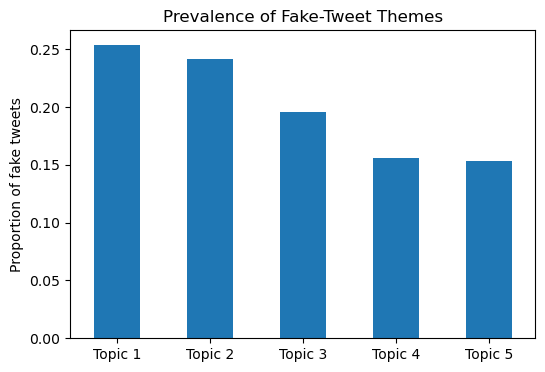

In [95]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt

# 1) Load the cleaned TRAIN split and filter fake tweets
df = pd.read_csv(r'/Users/brianwang/Desktop/2025 National Inter-University Research Project/constraint_train_clean.csv')      # columns: text, label
fake_texts = df[df["label"] == 0]["text"].tolist()  # 0 = fake

# 2) Vectorize with CountVectorizer
cv = CountVectorizer(
    max_df=0.8,        # drop very common tokens
    min_df=10,         # drop very rare tokens
    stop_words="english",
    ngram_range=(1,2)  # include unigrams and bigrams
)
X_cv = cv.fit_transform(fake_texts)

# 3) Fit LDA for 5 topics
lda = LatentDirichletAllocation(
    n_components=5,
    random_state=42,
    learning_method="batch",
    max_iter=10
)
lda.fit(X_cv)

# 4) Display top words per topic
def show_topics(model, vectorizer, n_top=8):
    words = vectorizer.get_feature_names_out()
    for i, comp in enumerate(model.components_):
        top_idx = comp.argsort()[-n_top:][::-1]
        topic_words = ", ".join(words[j] for j in top_idx)
        print(f"Topic {i+1}: {topic_words}")

show_topics(lda, cv)

# 5) Compute and plot topic prevalences
topic_dist = lda.transform(X_cv)
topic_ids  = topic_dist.argmax(axis=1)
prevalence = pd.Series(topic_ids).value_counts(normalize=True).sort_index()

plt.figure(figsize=(6,4))
prevalence.plot.bar()
plt.xticks(range(5), [f"Topic {i+1}" for i in range(5)], rotation=0)
plt.ylabel("Proportion of fake tweets")
plt.title("Prevalence of Fake-Tweet Themes")
plt.show()


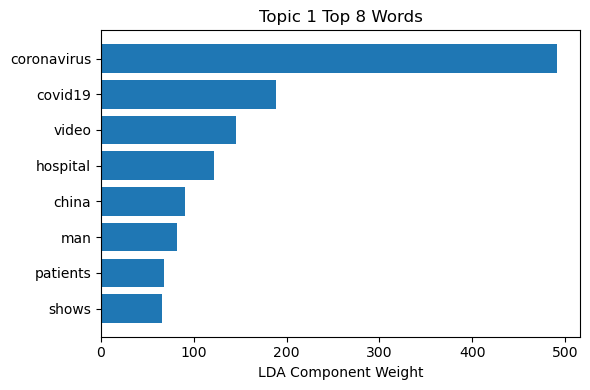

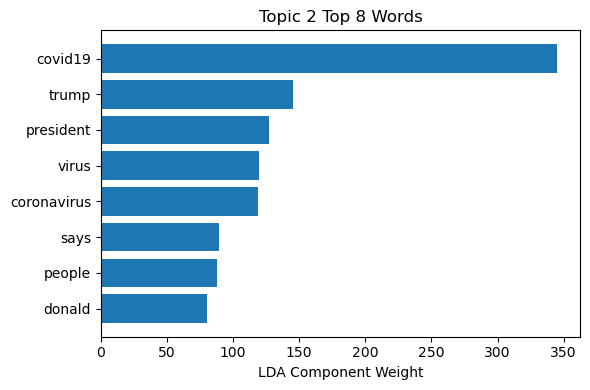

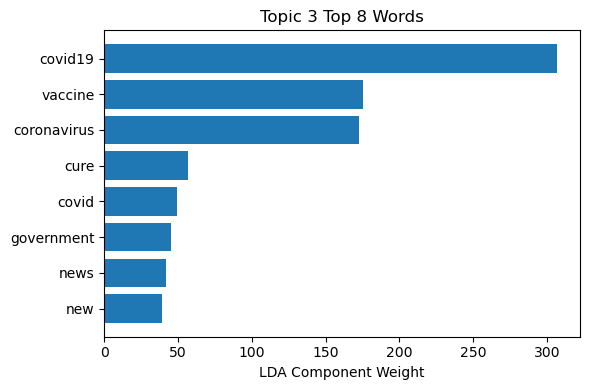

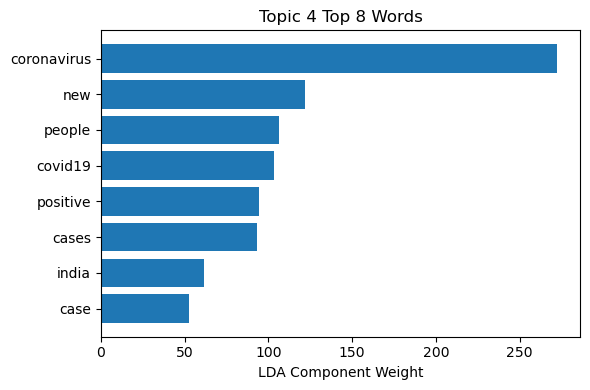

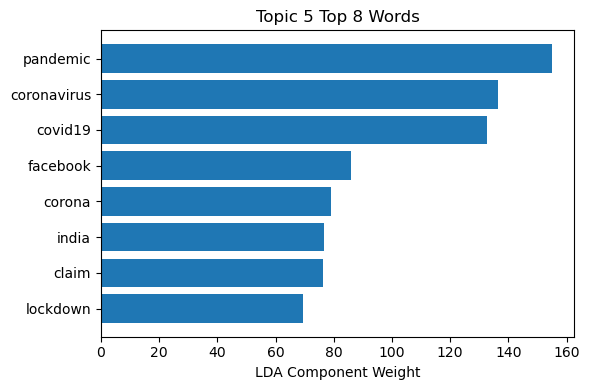

In [97]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pandas as pd

# Load fake tweets
df = pd.read_csv(r'/Users/brianwang/Desktop/2025 National Inter-University Research Project/constraint_train_clean.csv')
fake_texts = df[df["label"] == 0]["text"].tolist()

# Vectorize and fit LDA
cv = CountVectorizer(max_df=0.8, min_df=10, stop_words="english", ngram_range=(1,2))
X_cv = cv.fit_transform(fake_texts)
lda = LatentDirichletAllocation(n_components=5, random_state=42, learning_method="batch", max_iter=10)
lda.fit(X_cv)

# Prepare and plot top words for each topic
words = cv.get_feature_names_out()
n_top = 8

for topic_idx, comp in enumerate(lda.components_):
    top_idx = comp.argsort()[-n_top:][::-1]
    top_words = [words[i] for i in top_idx]
    top_vals = comp[top_idx]
    
    plt.figure(figsize=(6, 4))
    plt.barh(top_words[::-1], top_vals[::-1])
    plt.xlabel("LDA Component Weight")
    plt.title(f"Topic {topic_idx+1} Top {n_top} Words")
    plt.tight_layout()
    plt.show()


In [101]:
!pip install wordcloud


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.9/168.9 kB 1.9 MB/s eta 0:00:00a 0:00:01


Saved topic_1.png
Saved topic_2.png
Saved topic_3.png
Saved topic_4.png
Saved topic_5.png


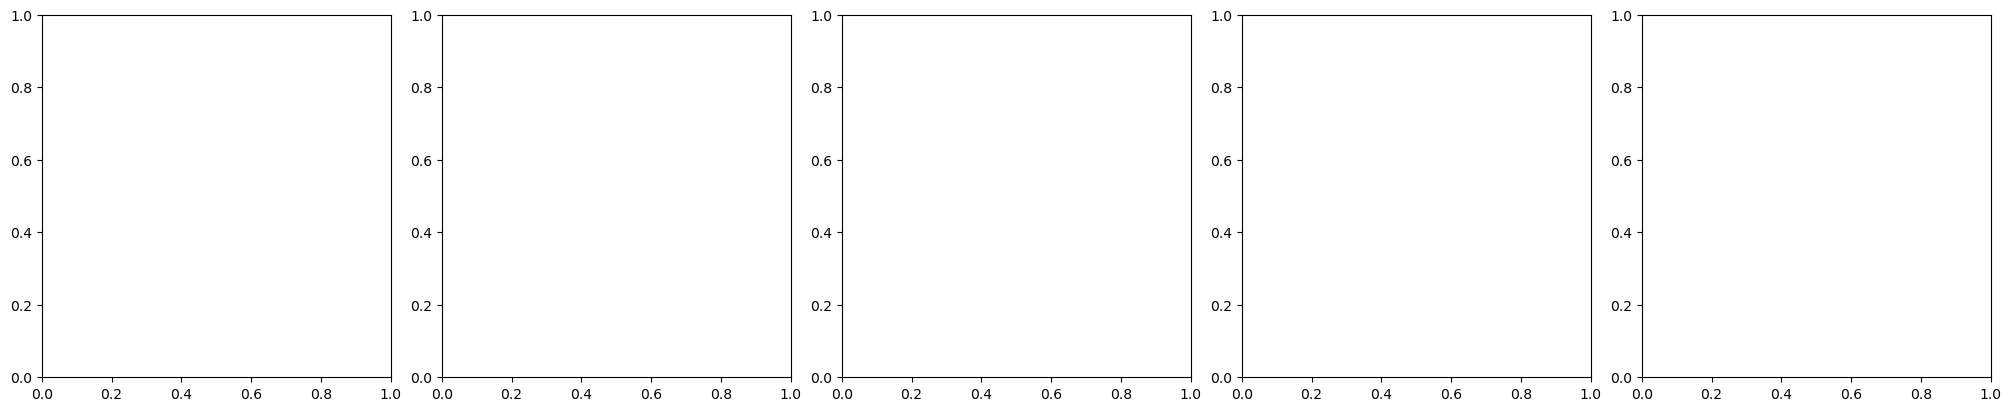

In [36]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# 1) Load cleaned train split and filter fake tweets
df = pd.read_csv(r'/Users/brianwang/Desktop/2025 National Inter-University Research Project/constraint_train_clean.csv')
fake_texts = df[df["label"] == 0]["text"].tolist()

# 2) Vectorize with CountVectorizer
cv = CountVectorizer(max_df=0.8, min_df=10, stop_words="english", ngram_range=(1,2))
X_cv = cv.fit_transform(fake_texts)

# 3) Fit LDA for 5 topics
lda = LatentDirichletAllocation(n_components=5, random_state=42, learning_method="batch", max_iter=10)
lda.fit(X_cv)

# 4) Generate word clouds for each topic
words = cv.get_feature_names_out()


fig, axes = plt.subplots(1, 5, figsize=(20, 4), constrained_layout=True)
for topic_idx, comp in enumerate(lda.components_):
    freqs = {words[i]: comp[i] for i in range(len(words))}
    wc = WordCloud(width=400, height=400, background_color="white") \
            .generate_from_frequencies(freqs)
    # Save each as its own file:
    wc.to_file(f'topic_{topic_idx+1}.png')
    print(f"Saved topic_{topic_idx+1}.png")



In [111]:
!pip install praw

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 kB 2.2 MB/s eta 0:00:00a 0:00:01


In [129]:
! pip install --upgrade openai


In [141]:
!pip install transformers


In [6]:
import requests, pandas as pd, re, string

# 1) Fetch recent posts via Reddit JSON API
def fetch_reddit_json(subreddit, limit=100):
    url = f"https://www.reddit.com/r/{subreddit}/new.json?limit={limit}"
    headers = {"User-Agent": "covid-misinfo-detector/0.1"}
    r = requests.get(url, headers=headers)
    r.raise_for_status()
    items = r.json()["data"]["children"]
    texts = []
    for child in items:
        data = child["data"]
        txt = (data.get("title","") or "") + " " + (data.get("selftext","") or "")
        texts.append(txt)
    return texts

docs = fetch_reddit_json("AskDocs", limit=100)
srs = fetch_reddit_json("seniors",  limit=100)
df_reddit = pd.DataFrame({"text": docs + srs})

# 2) Clean function
def clean(text):
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    return text.lower().strip()

df_reddit["text_clean"] = df_reddit["text"].apply(clean)
print("Rebuilt df_reddit with", len(df_reddit), "posts")


Rebuilt df_reddit with 200 posts


In [10]:
import requests, pandas as pd, re, string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# 1) Fetch & clean Reddit posts
def fetch_reddit(sub, limit=100):
    url = f"https://www.reddit.com/r/{sub}/new.json?limit={limit}"
    hdr = {"User-Agent":"covid-misinfo-detector/0.1"}
    r = requests.get(url, headers=hdr); r.raise_for_status()
    items = r.json()["data"]["children"]
    texts = []
    for c in items:
        d = c["data"]
        txt = (d.get("title","") or "") + " " + (d.get("selftext","") or "")
        # clean:
        txt = re.sub(r"http\S+","", txt)
        txt = re.sub(r"@\w+","", txt)
        txt = re.sub(r"#","", txt)
        txt = txt.translate(str.maketrans("","", string.punctuation))
        texts.append(txt.lower().strip())
    return texts

docs  = fetch_reddit("AskDocs", 100)
srs   = fetch_reddit("seniors",  100)
df_ext = pd.DataFrame({"text": docs + srs})

# 2) Rule‐based pseudo‐labels
fake_kw = ["miracle","cure","microchip","conspiracy","plandemic","secret"]
real_kw = ["cdc","who","study","research","journal","evidence","approved"]
def rule_label(t):
    t = t.lower()
    if any(f in t for f in fake_kw): return 0
    if any(r in t for r in real_kw): return 1
    return 1

df_ext["label"] = df_ext["text"].apply(rule_label)

# 3) TF–IDF + Logistic on the constraint‐train
train_df = pd.read_csv(r'/Users/brianwang/Desktop/2025 National Inter-University Research Project/constraint_train_clean.csv')
tfidf    = TfidfVectorizer(ngram_range=(1,2), min_df=5, max_df=0.8,
                           stop_words="english", sublinear_tf=True)
X_tr     = tfidf.fit_transform(train_df["text"])
y_tr     = train_df["label"]
clf      = LogisticRegression(max_iter=200, random_state=42,
                              class_weight="balanced")
clf.fit(X_tr, y_tr)

# 4) Evaluate on Reddit
X_ext    = tfidf.transform(df_ext["text"])
print("External (Reddit) via Rule‐Labels → TF–IDF Report:\n",
      classification_report(df_ext["label"], clf.predict(X_ext),
                            target_names=["fake","real"]))
print("AUC:", roc_auc_score(df_ext["label"],
                            clf.predict_proba(X_ext)[:,1]))


External (Reddit) via Rule‐Labels → TF–IDF Report:
               precision    recall  f1-score   support

        fake       0.02      0.50      0.04         4
        real       0.98      0.58      0.73       196

    accuracy                           0.57       200
   macro avg       0.50      0.54      0.39       200
weighted avg       0.96      0.57      0.71       200

AUC: 0.6224489795918368


Chart saved to performance_comparison.png


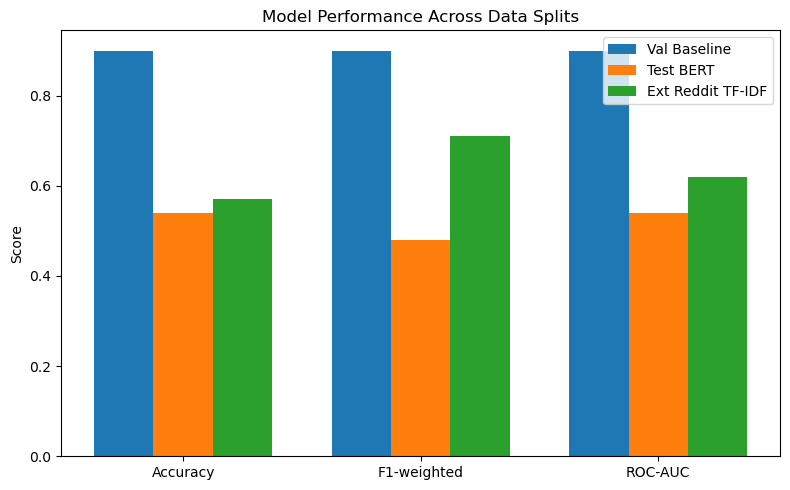

In [12]:
import matplotlib.pyplot as plt
import numpy as np

labels       = ['Accuracy', 'F1-weighted', 'ROC-AUC']
val_baseline = [0.90, 0.90, 0.90]
test_bert    = [0.54, 0.48, 0.54]
external_tf  = [0.57, 0.71, 0.62]

x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(8,5))
plt.bar(x - width, val_baseline, width, label='Val Baseline')
plt.bar(x,        test_bert,    width, label='Test BERT')
plt.bar(x + width, external_tf,  width, label='Ext Reddit TF-IDF')
plt.xticks(x, labels)
plt.ylabel('Score')
plt.title('Model Performance Across Data Splits')
plt.legend()
plt.tight_layout()

plt.savefig('performance_comparison.png')
print("Chart saved to performance_comparison.png")


In [14]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report, roc_auc_score

# --- 1) Prepare test set loader ---
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.enc = tokenizer(texts, truncation=True, 
                             padding="max_length", max_length=max_length)
        self.labels = labels
    def __len__(self): return len(self.labels)
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k,v in self.enc.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

# load & clean
df_test = pd.read_csv(r'/Users/brianwang/Desktop/2025 National Inter-University Research Project/english_test_with_labels.csv')
df_test["clean"] = df_test["tweet"].apply(clean)   # your clean() fn
df_test["label_int"] = df_test["label"].map({"fake":0,"real":1})

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
test_ds = TextDataset(df_test["clean"].tolist(),
                      df_test["label_int"].tolist(),
                      tokenizer)
test_loader = DataLoader(test_ds, batch_size=32)

# --- 2) Rebuild & load fine-tuned BERT ---
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained(
            "bert-base-uncased", num_labels=2
        )
state = torch.load("best_bert_constraint.pt", map_location=device)
model.load_state_dict(state)
model.to(device)
model.eval()

# --- 3) Evaluate on test split ---
all_preds, all_probs, all_labels = [], [], []
with torch.no_grad():
    for batch in test_loader:
        inputs = {k:v.to(device) for k,v in batch.items() if k!="labels"}
        labels = batch["labels"].numpy()
        logits = model(**inputs).logits.cpu().numpy()
        probs = torch.softmax(torch.tensor(logits), dim=-1)[:,1].numpy()
        preds = logits.argmax(axis=-1)
        all_labels.extend(labels)
        all_preds.extend(preds)
        all_probs.extend(probs)

print("BERT on Final Test (reloaded checkpoint):")
print(classification_report(all_labels, all_preds, target_names=["fake","real"]))
print("Test ROC-AUC:", roc_auc_score(all_labels, all_probs))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERT on Final Test (reloaded checkpoint):
              precision    recall  f1-score   support

        fake       0.56      0.19      0.29      1020
        real       0.54      0.86      0.66      1120

    accuracy                           0.54      2140
   macro avg       0.55      0.53      0.47      2140
weighted avg       0.55      0.54      0.48      2140

Test ROC-AUC: 0.5392082457983194


In [22]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer

# TextDataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.enc = tokenizer(
            texts,
            truncation=True,
            padding="max_length",
            max_length=max_length,
            return_tensors="pt"
        )
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {k: v[idx] for k, v in self.enc.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

# Load & clean dev CSV
import pandas as pd
df_dev = pd.read_csv(r'/Users/brianwang/Desktop/2025 National Inter-University Research Project/Constraint_Val.csv')
df_dev["clean"]   = df_dev["tweet"].apply(clean)          # your clean()
df_dev["label_i"] = df_dev["label"].map({"fake":0,"real":1})

# Tokenizer + Dataset + DataLoader
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
dev_ds     = TextDataset(df_dev["clean"].tolist(),
                          df_dev["label_i"].tolist(),
                          tokenizer)
dev_loader = DataLoader(dev_ds, batch_size=32, shuffle=False)


In [24]:
from transformers import AutoModelForSequenceClassification
from sklearn.metrics import classification_report, roc_auc_score

# device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# rebuild & load fine-tuned model
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=2
)
state = torch.load("best_bert_constraint.pt", map_location=device)
model.load_state_dict(state)
model.to(device)
model.eval()

# run evaluation
all_preds, all_probs, all_labels = [], [], []
with torch.no_grad():
    for batch in dev_loader:
        # move inputs to device
        inputs = {k: v.to(device) for k,v in batch.items() if k!="labels"}
        labels = batch["labels"].cpu().numpy()

        logits = model(**inputs).logits.cpu().numpy()
        probs  = torch.softmax(torch.tensor(logits), dim=-1)[:,1].numpy()
        preds  = logits.argmax(axis=-1)

        all_labels.extend(labels)
        all_preds.extend(preds)
        all_probs.extend(probs)

print("BERT on Dev Split (reloaded checkpoint):")
print(classification_report(all_labels, all_preds, target_names=["fake","real"]))
print("Dev ROC-AUC:", roc_auc_score(all_labels, all_probs))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERT on Dev Split (reloaded checkpoint):
              precision    recall  f1-score   support

        fake       0.52      0.18      0.27      1020
        real       0.53      0.85      0.65      1120

    accuracy                           0.53      2140
   macro avg       0.53      0.51      0.46      2140
weighted avg       0.53      0.53      0.47      2140

Dev ROC-AUC: 0.536311712184874


In [30]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

# Load and clean the Reddit data
# Vectorize using simple counts 
vectorizer = CountVectorizer(min_df=5, stop_words="english")
X_train_counts = vectorizer.fit_transform(train_df["text"])   # train_df from constraint_train_clean.csv
y_train = train_df["label"]

# 3) Train Multinomial Naive Bayes
nb = MultinomialNB()
nb.fit(X_train_counts, y_train)

# 4) Apply to Reddit posts
X_reddit_counts = vectorizer.transform(df_reddit["text_clean"])
probs = nb.predict_proba(X_reddit_counts)
df_reddit["p_fake_nb"] = probs[:, 0]
df_reddit["p_real_nb"] = probs[:, 1]

# 5) High-confidence thresholding (>=0.90)
thresh = 0.90
high_conf = df_reddit[(df_reddit["p_fake_nb"] >= thresh) | (df_reddit["p_real_nb"] >= thresh)].copy()
high_conf["label_nb"] = nb.predict(vectorizer.transform(high_conf["text_clean"]))

# 6) Overview of results
print(f"Selected {len(high_conf)} high-confidence posts out of {len(df_reddit)} total\n")

# Display all high-confidence pseudo-labels
cols = ["text_clean", "p_fake_nb", "p_real_nb", "label_nb"]
print(high_conf[cols].to_string(index=False))


Selected 158 high-confidence posts out of 200 total

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [32]:
from sklearn.metrics import classification_report, roc_auc_score

# Transform and predict
X_hc = tfidf.transform(high_conf["text_clean"])
y_hc = high_conf["label_nb"]  # high_conf labels from NB

preds_hc = clf.predict(X_hc)
probs_hc = clf.predict_proba(X_hc)[:,1]

print("High-Confidence External TF-IDF Report:\n",
      classification_report(y_hc, preds_hc, target_names=["fake","real"]))
print("High-Confidence External AUC:", roc_auc_score(y_hc, probs_hc))


High-Confidence External TF-IDF Report:
               precision    recall  f1-score   support

        fake       1.00      0.54      0.70       137
        real       0.25      1.00      0.40        21

    accuracy                           0.60       158
   macro avg       0.62      0.77      0.55       158
weighted avg       0.90      0.60      0.66       158

High-Confidence External AUC: 0.8821689259645464


In [34]:
from torch.utils.data import DataLoader, Dataset
import torch

# Wrap into Dataset/DataLoader
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.enc = tokenizer(texts, truncation=True, padding="max_length", max_length=max_length)
        self.labels = labels
    def __len__(self): return len(self.labels)
    def __getitem__(self, i):
        item = {k: torch.tensor(v[i]) for k,v in self.enc.items()}
        item["labels"] = torch.tensor(self.labels[i])
        return item

hc_ds     = TextDataset(high_conf["text_clean"].tolist(),
                        high_conf["label_nb"].tolist(),
                        tokenizer)
hc_loader = DataLoader(hc_ds, batch_size=16)

all_preds, all_probs, all_labels = [], [], []
model.eval()
with torch.no_grad():
    for batch in hc_loader:
        inputs = {k:v.to(device) for k,v in batch.items() if k!="labels"}
        logits = model(**inputs).logits.cpu().numpy()
        probs  = torch.softmax(torch.tensor(logits), dim=-1)[:,1].numpy()
        preds  = logits.argmax(axis=-1)

        all_labels.extend(batch["labels"].numpy())
        all_preds.extend(preds)
        all_probs.extend(probs)

print("High-Confidence External BERT Report:\n",
      classification_report(all_labels, all_preds, target_names=["fake","real"]))
print("High-Confidence External AUC:", roc_auc_score(all_labels, all_probs))


High-Confidence External BERT Report:
               precision    recall  f1-score   support

        fake       0.89      0.31      0.46       137
        real       0.14      0.76      0.24        21

    accuracy                           0.37       158
   macro avg       0.52      0.53      0.35       158
weighted avg       0.79      0.37      0.43       158

High-Confidence External AUC: 0.5126868265554396


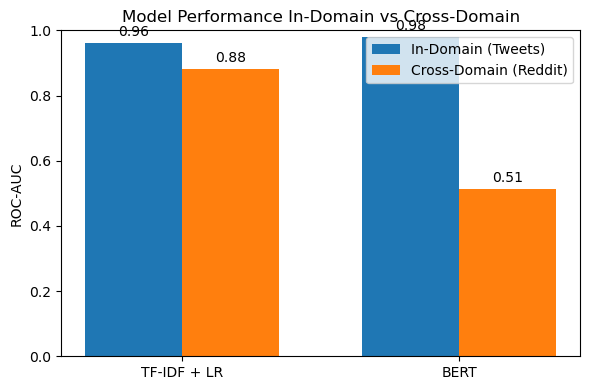

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['TF-IDF + LR', 'BERT']
auc_tweets = [0.96, 0.98]
auc_reddit = [0.8822, 0.5127]

x = np.arange(len(models))  # label locations
width = 0.35  # width of the bars

fig, ax = plt.subplots(figsize=(6, 4))
rects1 = ax.bar(x - width/2, auc_tweets, width, label='In-Domain (Tweets)')
rects2 = ax.bar(x + width/2, auc_reddit, width, label='Cross-Domain (Reddit)')

# Add labels, title, and custom x-axis tick labels
ax.set_ylabel('ROC-AUC')
ax.set_ylim(0, 1.0)
ax.set_title('Model Performance In-Domain vs Cross-Domain')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Annotate bars with values
for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}', 
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()


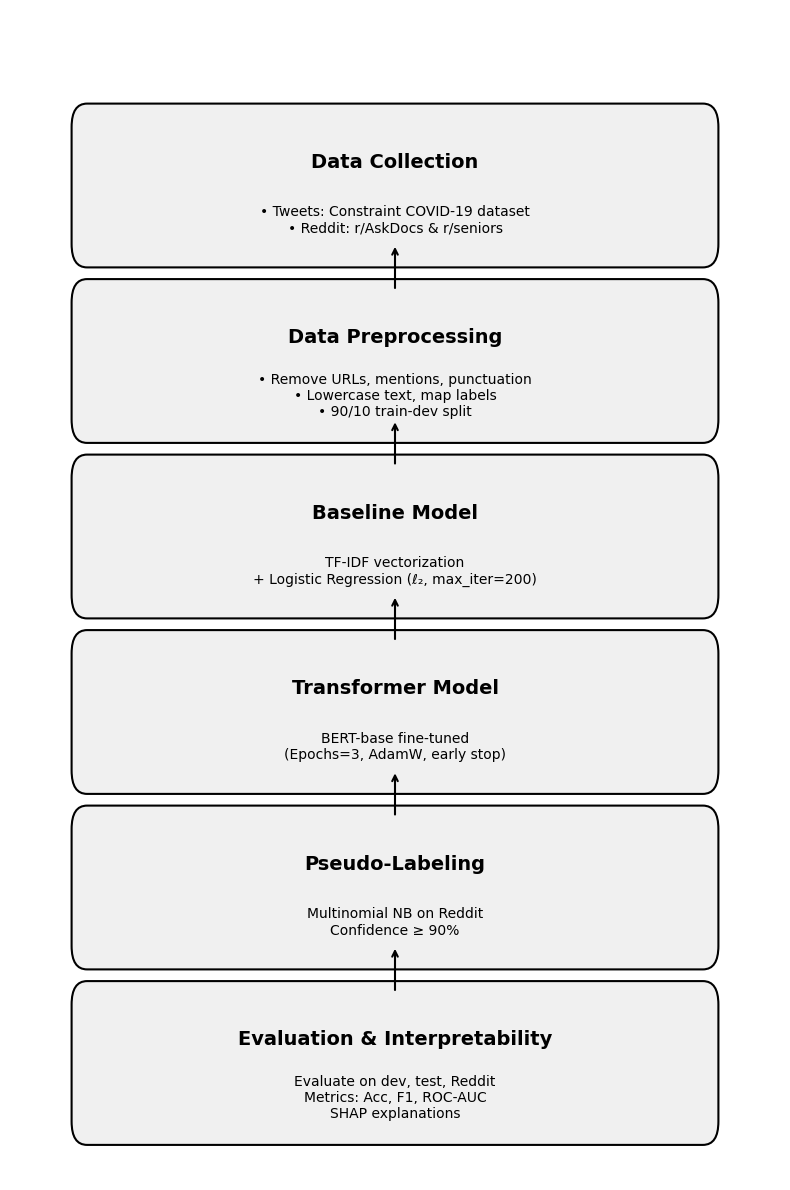

In [40]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch

# Create figure
fig, ax = plt.subplots(figsize=(8, 12))
ax.axis('off')

# Define pipeline steps and their positions
steps = [
    ("Data Collection", "• Tweets: Constraint COVID-19 dataset\n• Reddit: r/AskDocs & r/seniors"),
    ("Data Preprocessing", "• Remove URLs, mentions, punctuation\n• Lowercase text, map labels\n• 90/10 train-dev split"),
    ("Baseline Model", "TF-IDF vectorization\n+ Logistic Regression (ℓ₂, max_iter=200)"),
    ("Transformer Model", "BERT-base fine-tuned\n(Epochs=3, AdamW, early stop)"),
    ("Pseudo-Labeling", "Multinomial NB on Reddit\nConfidence ≥ 90%"),
    ("Evaluation & Interpretability", "Evaluate on dev, test, Reddit\nMetrics: Acc, F1, ROC-AUC\nSHAP explanations")
]

# Draw boxes and arrows
y_start = 0.9
box_height = 0.1
y_gap = 0.05
for i, (title, content) in enumerate(steps):
    y = y_start - i * (box_height + y_gap)
    # Draw box
    box = FancyBboxPatch((0.1, y - box_height), 0.8, box_height, boxstyle="round,pad=0.02", 
                         linewidth=1.5, facecolor='#f0f0f0', edgecolor='black')
    ax.add_patch(box)
    # Add title
    ax.text(0.5, y - box_height/2 + 0.02, title, ha='center', va='center', fontsize=14, weight='bold')
    # Add content
    ax.text(0.5, y - box_height/2 - 0.03, content, ha='center', va='center', fontsize=10)

    # Draw arrow to next box
    if i < len(steps) - 1:
        ax.annotate("", xy=(0.5, y - box_height), xytext=(0.5, y - box_height - y_gap + 0.01),
                    arrowprops=dict(arrowstyle='->', lw=1.5))

plt.tight_layout()
plt.show()

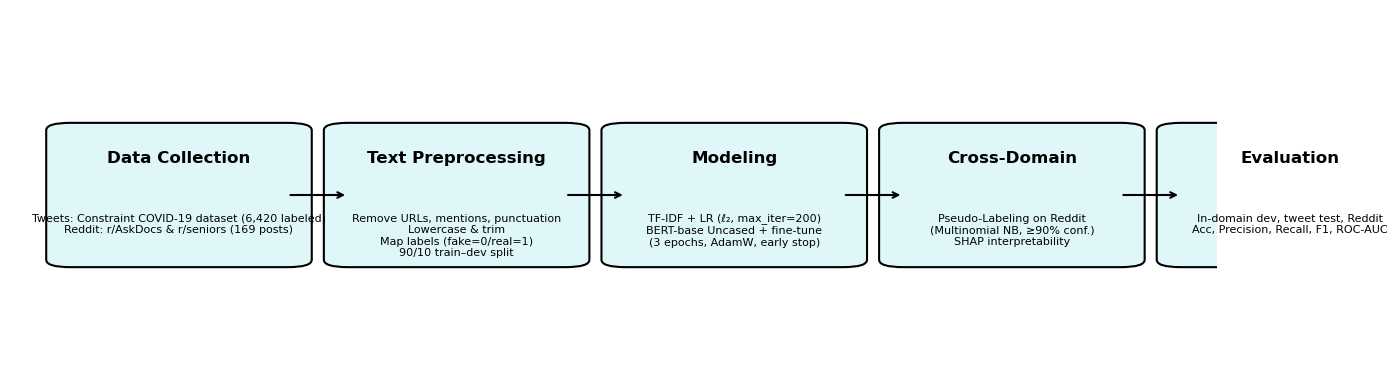

In [42]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch

fig, ax = plt.subplots(figsize=(14, 4))
ax.axis('off')

steps = [
    ("Data Collection", "Tweets: Constraint COVID-19 dataset (6,420 labeled)\nReddit: r/AskDocs & r/seniors (169 posts)"),
    ("Text Preprocessing", "Remove URLs, mentions, punctuation\nLowercase & trim\nMap labels (fake=0/real=1)\n90/10 train–dev split"),
    ("Modeling", "TF-IDF + LR (ℓ₂, max_iter=200)\nBERT-base Uncased + fine-tune\n(3 epochs, AdamW, early stop)"),
    ("Cross-Domain", "Pseudo-Labeling on Reddit\n(Multinomial NB, ≥90% conf.)\nSHAP interpretability"),
    ("Evaluation", "In-domain dev, tweet test, Reddit\nAcc, Precision, Recall, F1, ROC-AUC")
]

n = len(steps)
box_w, box_h = 0.18, 0.35
xs = [0.05 + i*0.23 for i in range(n)]
y = 0.5

# Draw
for x, (title, text) in zip(xs, steps):
    box = FancyBboxPatch((x, y-box_h/2), box_w, box_h,
                         boxstyle="round,pad=0.02", fc="#e0f7fa", ec="black", lw=1.5)
    ax.add_patch(box)
    ax.text(x+box_w/2, y+0.1, title, ha='center', va='center', fontsize=12, weight='bold')
    ax.text(x+box_w/2, y-0.05, text, ha='center', va='top', fontsize=8)

# Arrows
for i in range(n-1):
    ax.annotate("", xy=(xs[i+1], y), xytext=(xs[i]+box_w, y),
                arrowprops=dict(arrowstyle="->", lw=1.5))

plt.tight_layout()
plt.show()
